In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
df = pd.read_csv('/Users/cytology/Documents/code/datasets/all_english_audible.csv')

In [3]:
image_path = '/Users/cytology/Documents/code/figures/audible'

def save_fig(fig_name, tight_layout=True):
    path = os.path.join(image_path, fig_name + '.png')
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460544 entries, 0 to 460543
Data columns (total 11 columns):
asin            436796 non-null object
author          459624 non-null object
category        460544 non-null object
length          460524 non-null object
link            460544 non-null object
narrator        452241 non-null object
price           460395 non-null float64
rating          459742 non-null float64
rating_count    460527 non-null float64
release_date    460500 non-null object
title           460544 non-null object
dtypes: float64(3), object(8)
memory usage: 38.7+ MB


In [5]:
# Let's start by making sure we don't have duplicates. It's possible items are listed in multiple categories.
# So that we only take the version of a title with the most reviews, we'll first sort our dataframe by review_count.
df.sort_values('rating_count', ascending=False, inplace=True)
df.drop_duplicates(subset=['title', 'author', 'narrator'], keep='first', inplace=True) # Take the first (i.e. most reviews)
df.reset_index(drop=True)
df.info()

# From scraping, we know some entries have the author listed as 'nan'. Let's remove those.
df = df.dropna(subset=['author'], axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353395 entries, 247928 to 425840
Data columns (total 11 columns):
asin            336467 non-null object
author          352686 non-null object
category        353395 non-null object
length          353380 non-null object
link            353395 non-null object
narrator        346888 non-null object
price           353275 non-null float64
rating          352761 non-null float64
rating_count    353382 non-null float64
release_date    353360 non-null object
title           353395 non-null object
dtypes: float64(3), object(8)
memory usage: 32.4+ MB


Indeed, we've dropped about 90k duplicate entries.

In [6]:
df.head()

,asin,author,category,length,link,narrator,price,rating,rating_count,release_date,title
247928,B005FRGT44,Ernest Cline,Sci-Fi & Fantasy,15 hrs and 40 mins,https://www.audible.com/pd/Ready-Player-One-Au...,Wil Wheaton,31.50,5.0,216094.0,2011-08-16,Ready Player One
248009,B00B5HZGUG,Andy Weir,Sci-Fi & Fantasy,10 hrs and 53 mins,https://www.audible.com/pd/The-Martian-Audiobo...,R. C. Bray,29.99,5.0,164988.0,2013-03-22,The Martian
142087,B00QXW5GYY,Paula Hawkins,Mysteries & Thrillers,10 hrs and 58 mins,https://www.audible.com/pd/The-Girl-on-the-Tra...,"Clare Corbett, Louise Brealey, India Fisher",28.00,4.5,133818.0,2015-01-13,The Girl on the Train
4895,B01IW9TQPK,Trevor Noah,Bios & Memoirs,8 hrs and 44 mins,https://www.audible.com/pd/Born-a-Crime-Audiob...,Trevor Noah,24.95,5.0,123838.0,2016-11-15,Born a Crime
282008,B01I28NFEE,Mark Manson,Self Development,5 hrs and 17 mins,https://www.audible.com/pd/The-Subtle-Art-of-N...,Roger Wayne,23.95,4.5,113261.0,2016-09-13,The Subtle Art of Not Giving a F*ck


In [7]:
# Let's reorder the columns for ease of viewing.
cols = ['title', 'author', 'narrator', 'rating', 'rating_count', 'release_date', 'length', 'price', 'category', 'link', 'asin']
df = df[cols]

In [8]:
df.head()

,title,author,narrator,rating,rating_count,release_date,length,price,category,link,asin
247928,Ready Player One,Ernest Cline,Wil Wheaton,5.0,216094.0,2011-08-16,15 hrs and 40 mins,31.50,Sci-Fi & Fantasy,https://www.audible.com/pd/Ready-Player-One-Au...,B005FRGT44
248009,The Martian,Andy Weir,R. C. Bray,5.0,164988.0,2013-03-22,10 hrs and 53 mins,29.99,Sci-Fi & Fantasy,https://www.audible.com/pd/The-Martian-Audiobo...,B00B5HZGUG
142087,The Girl on the Train,Paula Hawkins,"Clare Corbett, Louise Brealey, India Fisher",4.5,133818.0,2015-01-13,10 hrs and 58 mins,28.00,Mysteries & Thrillers,https://www.audible.com/pd/The-Girl-on-the-Tra...,B00QXW5GYY
4895,Born a Crime,Trevor Noah,Trevor Noah,5.0,123838.0,2016-11-15,8 hrs and 44 mins,24.95,Bios & Memoirs,https://www.audible.com/pd/Born-a-Crime-Audiob...,B01IW9TQPK
282008,The Subtle Art of Not Giving a F*ck,Mark Manson,Roger Wayne,4.5,113261.0,2016-09-13,5 hrs and 17 mins,23.95,Self Development,https://www.audible.com/pd/The-Subtle-Art-of-N...,B01I28NFEE


In [9]:
# Let's find out which columns are incomplete.
def check_col_complete(dataframe):
    len_ = len(dataframe)

    incomplete = []
    for col in dataframe.columns:
        complete = dataframe[col].count() == len_
        if complete:
            print('{: >23}: COMPLETE'.format(col))
        else:
            missing = len_ - dataframe[col].count()
            incomplete.append(col)
            print('{: >23}: MISSING {} VALUES ({:.1f}%)'.format(col, missing, missing*100/len_))
    
    print('\nTotal number of items:', len_)

    return incomplete

incomplete_cols = check_col_complete(df)

                  title: COMPLETE
                 author: COMPLETE
               narrator: MISSING 6489 VALUES (1.8%)
                 rating: MISSING 634 VALUES (0.2%)
           rating_count: MISSING 13 VALUES (0.0%)
           release_date: MISSING 35 VALUES (0.0%)
                 length: MISSING 15 VALUES (0.0%)
                  price: MISSING 120 VALUES (0.0%)
               category: COMPLETE
                   link: COMPLETE
                   asin: MISSING 16897 VALUES (4.8%)

Total number of items: 352686


In [10]:
# Let's convert the release_date column to datetime objects.
df['release_date'] = pd.to_datetime(df['release_date'], infer_datetime_format=True)

In [11]:
# Now let's convert the duration to length in minutes.
def fix_len(x):
    if 'min' in x and 'hr' in x:
        hrs = int(x.split(' hr')[0]) * 60
        mins = int(x.split(' min')[0].split('and ')[1])
        len_ = hrs + mins
    elif 'min' in x:
        len_ = int(x.split(' min')[0])
    elif 'hr' in x:
        len_ = int(x.split(' hr')[0]) * 60
    else:
        len_ = 0
    return len_
df['length'] = df['length'].astype(str).apply(fix_len)

In [12]:
# Let's take the first author or narrator in situations with lists
df['author'] = df['author'].astype(str).apply(lambda x: x.split(',')[0])
df['narrator'] = df['narrator'].astype(str).apply(lambda x: x.split(',')[0])

In [13]:
# We're ready to start exploring. Broad questions first: How many hours of recordings are represented in our dataset?
tot_mins = df['length'].sum()
years = tot_mins / (60*24*365)
days = (years - int(years))*365
hours = (days - int(days))*24
mins = (hours - int(hours)) * 60
print('Total time: {} years, {} days, {} hours, {} minutes'.format(int(years), int(days), int(hours), int(mins)))

Total time: 230 years, 235 days, 15 hours, 52 minutes


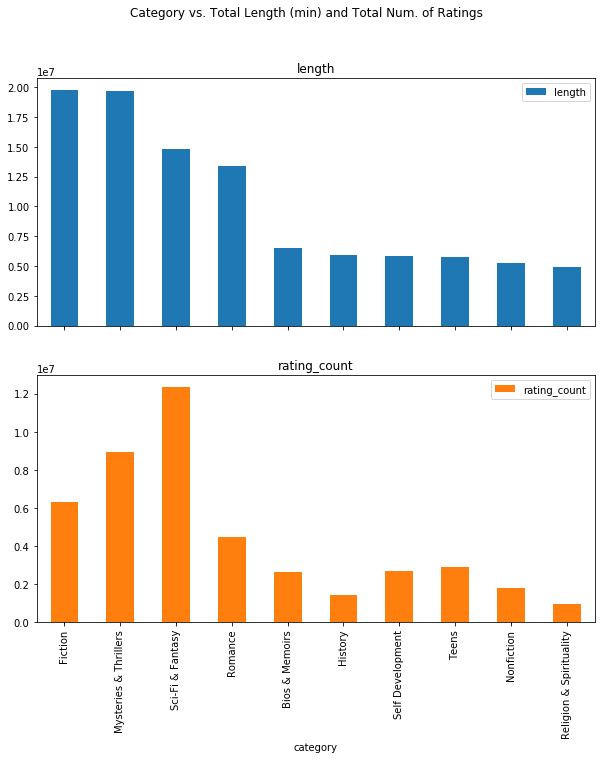

In [14]:
# How do the 'length' and 'rating_count' break down by genre?
df.groupby('category').sum().nlargest(10, 'length')[['length', 'rating_count']].plot(
    subplots=True, kind='bar', figsize=(10,10), title='Category vs. Total Length (min) and Total Num. of Ratings');

Interestingly, the top three categories by total length of offerings are the reverse of the top three by number of ratings. In other words, the engagement (i.e. number of reviews) per hour of content is much higher for 'Sci-Fi & Fantasy' programs than for 'Fiction'. Let's see if we can quantify further. Since the number of reviews per hour may be a less fair metric than the number of reviews per title (we assume some genres have longer titles than others, on average), let's adopt the latter. Let's see if the engagement trend continues with this alternate metric.

Saving figure Category vs. Engagement


category
Romance                  23.0
Sci-Fi & Fantasy         22.0
Mysteries & Thrillers    13.0
History                  10.0
Teens                     9.0
Bios & Memoirs            8.0
Nonfiction                8.0
Fiction                   7.0
Classics                  6.0
Sports                    6.0
Name: rating_count, dtype: float64

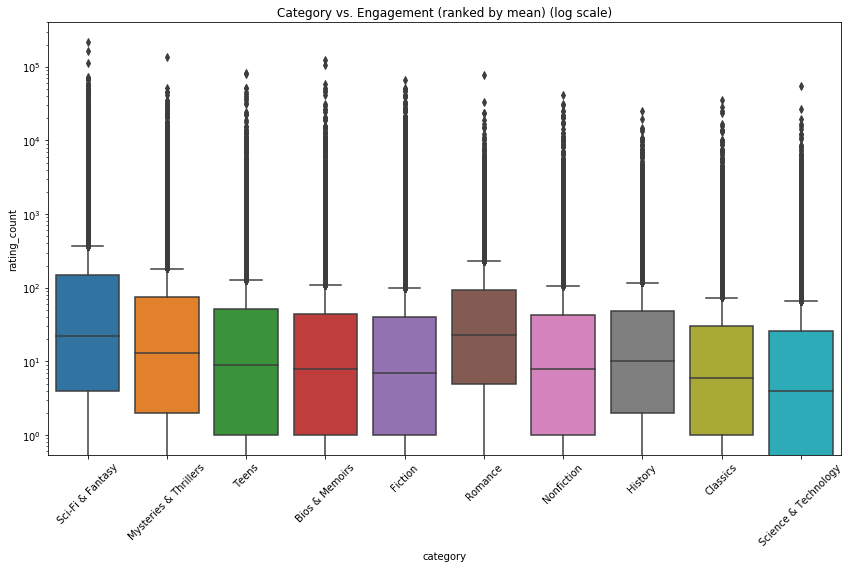

In [15]:
cols = df.groupby('category')['rating_count'].mean().nlargest(10).index
plt.figure(figsize=(12,8))
bplot = sns.boxplot(x='category', y='rating_count', 
                    data=df[(df['category'].isin(cols))], order=cols)
bplot.set_title('Category vs. Engagement (ranked by mean) (log scale)')
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, fontsize=10)
plt.yscale('log')
save_fig('Category vs. Engagement')

df.groupby('category')['rating_count'].median().nlargest(10)

A couple of interesting findings here: First, 'Sci-Fi & Fantasy' continues to have the highest engagment by average number of reviews per title. Yet now it loses to 'Romance' when considering the median number of reviews rather than the mean. Furthermore, the distribution of 'Romance' reviews is tighter than that of any other category here. These findings taken together suggest that 'Romance' has a more bimodal distrubution than other categories. We should expect that a larger percentage of titles have few or no reviews, bringing the mean down. However the titles that are popular are getting a lot of reviews each, bringing the median up. In other words, 'Romance' listeners are less adventurous in their program selection than some other genre listeners.

Saving figure Rating Count vs Number of Titles


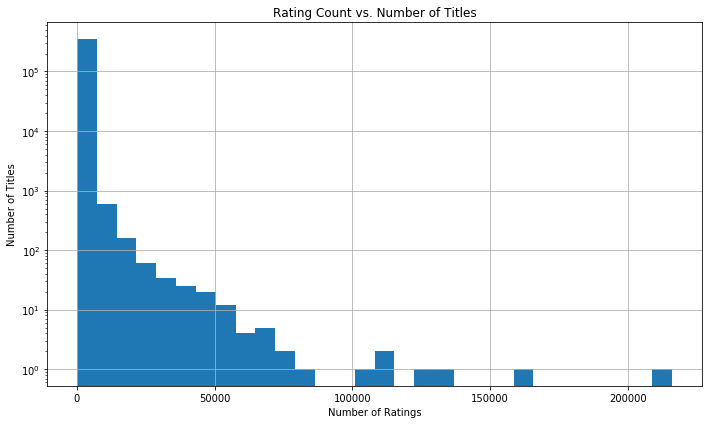

In [31]:
# Let's take a look at 'rating_count' more closely
fig = plt.figure(figsize=(10,6))
ax = df['rating_count'].hist(bins=30, log=True)
ax.set_xlabel('Number of Ratings')
ax.set_ylabel('Number of Titles')
ax.set(title='Rating Count vs. Number of Titles')
# plt.show()
save_fig('Rating Count vs Number of Titles')

Note the logarithmic scale on the y-axis, which allows us to see very high and low values. It looks like there are only a handful of titles north of 100,000 ratings, and only one with more than 200,000.

In [17]:
# Let's view the 10 most popular programs.
df.nlargest(10, 'rating_count')[['title', 'author', 'rating_count']]

,title,author,rating_count
247928,Ready Player One,Ernest Cline,216094.0
248009,The Martian,Andy Weir,164988.0
142087,The Girl on the Train,Paula Hawkins,133818.0
4895,Born a Crime,Trevor Noah,123838.0
282008,The Subtle Art of Not Giving a F*ck,Mark Manson,113261.0
247907,A Game of Thrones,George R. R. Martin,111587.0
4892,Becoming,Michelle Obama,103990.0
443255,"Harry Potter and the Sorcerer's Stone, Book 1",J.K. Rowling,81675.0
443261,"Harry Potter and the Deathly Hallows, Book 7",J.K. Rowling,78518.0
189314,Where the Crawdads Sing,Delia Owens,77977.0


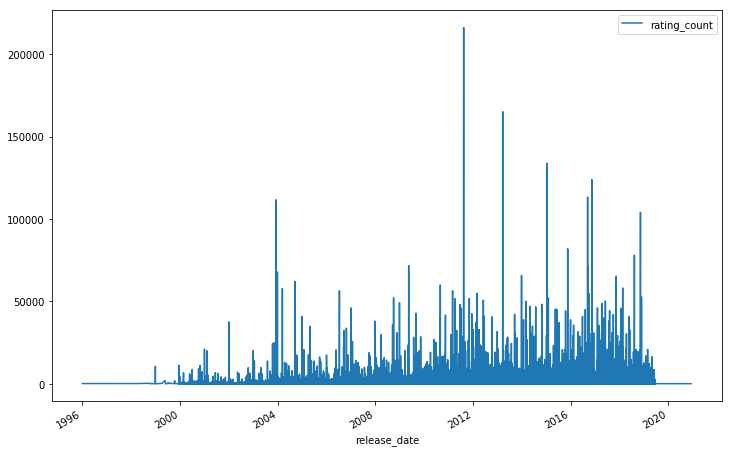

Saving figure Release date vs Rating Count


<Figure size 432x288 with 0 Axes>

In [18]:
# Let's see how the date of release relates to rating_count. 
df.plot(x='release_date', y='rating_count', kind='line', figsize=(12,8))
plt.show()
save_fig('Release date vs Rating Count')

Saving figure Author vs Ratings


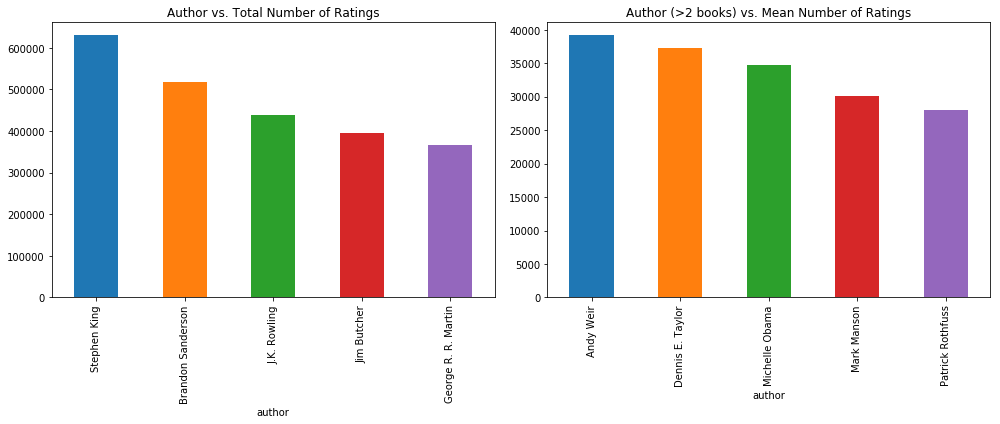

In [32]:
# Which authors have the most ratings over their ouvre?
top_authors = df.groupby('author', sort=True)
plt.subplot(1, 2, 1)
top_authors.sum().nlargest(5, 'rating_count')['rating_count'].plot(
    kind='bar', figsize=(14, 6), title='Author vs. Total Number of Ratings')

# Which authors with more than one book have the highest average number of reviews?
plt.subplot(1, 2, 2)
auth_df = df.groupby('author')['rating_count'].agg([np.size, np.mean])
auth_df[auth_df['size']>2].nlargest(5, 'mean')['mean'].plot(
    kind='bar', figsize=(14, 6), title='Author (>2 books) vs. Mean Number of Ratings')
# plt.show()
save_fig('Author vs Ratings')

Saving figure Narrator vs Ratings


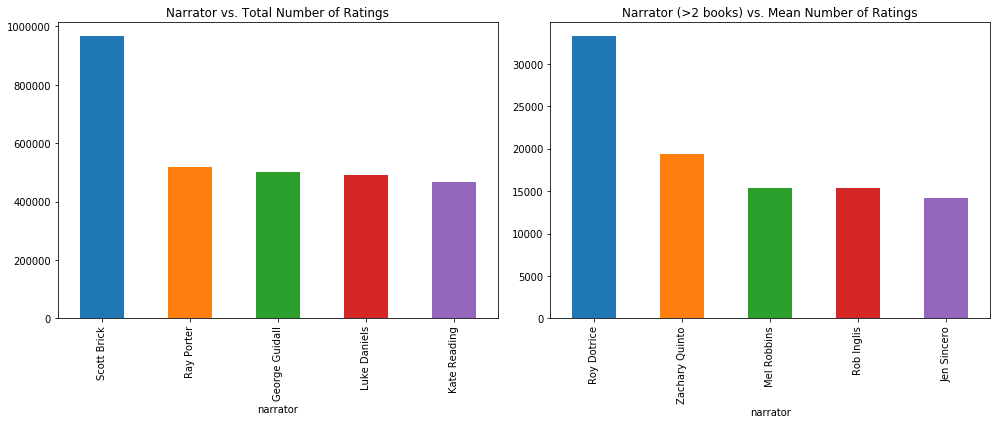

In [33]:
# Which narrators have the most ratings over their ouvre?
top_narrators = df.groupby('narrator', sort=True)
plt.subplot(1, 2, 1)
top_narrators.sum().nlargest(5, 'rating_count')['rating_count'].plot(
    kind='bar', figsize=(14, 6), title='Narrator vs. Total Number of Ratings')

# Which narrators with more than one book have the highest average number of reviews?
plt.subplot(1, 2, 2)
narr_df = df.groupby('narrator')['rating_count'].agg([np.size, np.mean])
narr_df[narr_df['size']>2].nlargest(5, 'mean')['mean'].plot(
    kind='bar', figsize=(14, 6), title='Narrator (>2 books) vs. Mean Number of Ratings')
# plt.show()
save_fig('Narrator vs Ratings')

Saving figure Author vs Duration


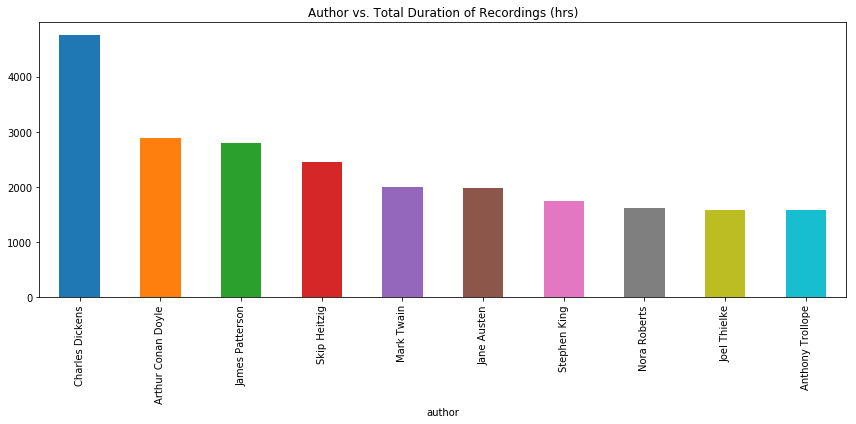

In [21]:
# Who are the most prolific/most recorded authors on Audible? 
# (Excluding the companies 'Pimsleur' and 'Charles River Editors')
auth_excl = ['Pimsleur', 'Charles River Editors']
df[~df['author'].isin(auth_excl)].groupby('author')['length'].sum().apply(lambda x: x/60).nlargest(10).plot(
    kind='bar', title='Author vs. Total Duration of Recordings (hrs)', figsize=(12,6));
save_fig('Author vs Duration')

Charles Dickens takes the prize with close to 5,000 hours of recordings on Audible. Note that the top two authors benefit from having duplicates of several of their books. Let's take a look at one example:

In [22]:
# How many versions of A Tale of Two Cities are on Audible?
atotc_num = len(df[(df['author'] == 'Charles Dickens') & df['title'].str.contains('A Tale of Two Cities')])
print("%i versions of 'A Tale of Two Cities'" % atotc_num)

37 versions of 'A Tale of Two Cities'


Saving figure Narrator vs Duration


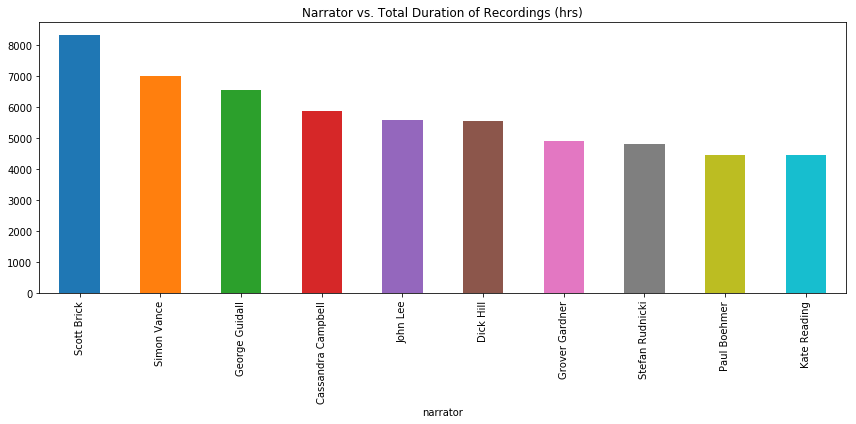

In [23]:
# Which narrators have the most hours of recordings? (Excluding unknown narrator,'nan', and 'full cast')
narr_excl = ['nan', 'full cast']
df[~df['narrator'].isin(narr_excl)].groupby('narrator')['length'].sum().apply(lambda x: x/60).nlargest(10).plot(
    kind='bar', title='Narrator vs. Total Duration of Recordings (hrs)', figsize=(12,6));
save_fig('Narrator vs Duration')

So Scott Brick wins this one with nearly double the length of all of Charles Dickens' recordings. The guy's clearly been busy.

Saving figure Price vs Frequency


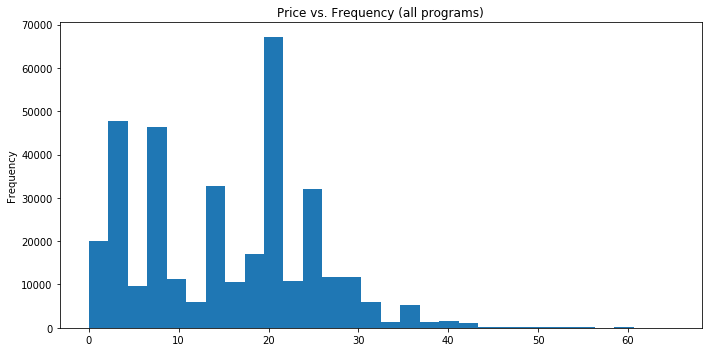

In [24]:
# Let's switch gears and explore prices.
df['price'].plot(kind='hist', figsize=(10,5), bins=30, title='Price vs. Frequency (all programs)', range=(0,65));
df['price'].mean()
save_fig('Price vs Frequency')

The mean price of all books is $15.43, which incidentally is near the ~$15 price per credit for some of the Audible monthly plans. There are spikes at every $5 interval as we'd expect given _4.99 and _9.99 pricing schemes.

category
Mysteries & Thrillers    20.532934
Sci-Fi & Fantasy         20.269023
Teens                    19.668533
Name: price, dtype: float64
category
Newspapers & Magazines    2.812708
Radio & TV                5.157081
Live Events               6.969252
Name: price, dtype: float64
Saving figure Category vs Price


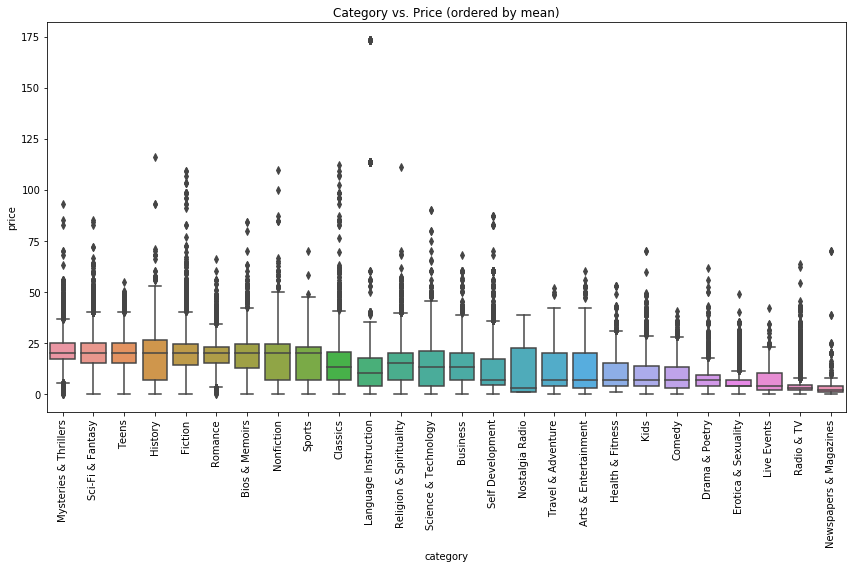

In [25]:
cols = df.groupby('category')['price'].mean().nlargest(26).index
plt.figure(figsize=(12,8))
bplot = sns.boxplot(x='category', y='price', 
                    data=df[(df['category'].isin(cols))], order=cols)
bplot.set_title('Category vs. Price (ordered by mean)')
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=90, fontsize=10);
print(df.groupby('category')['price'].mean().nlargest(3))
print(df.groupby('category')['price'].mean().nsmallest(3))
save_fig('Category vs Price')

'Mysteries & Thrillers' has the largest average price at $20.53. 'Newspapers & Magazines' has the cheapest average price at $2.81. No big surprises here.
We can see from our boxplot our likely most expensive title -- the outlier in the 'Language Instruction' category. Let's find out what it is.

In [26]:
# The most expensive English program on Audible
print(df.loc[df['price'].idxmax()])
print(df.loc[df['price'].idxmax()]['link'])

title                                    Pimsleur Spanish Level 2
author                                                   Pimsleur
narrator                                                 Pimsleur
rating                                                        4.5
rating_count                                                  156
release_date                                  2010-04-01 00:00:00
length                                                        982
price                                                      173.27
category                                     Language Instruction
link            https://www.audible.com/pd/Pimsleur-Spanish-Le...
asin                                                   B00384HI5K
Name: 400582, dtype: object
https://www.audible.com/pd/Pimsleur-Spanish-Level-2-Audiobook/B00384HI5K?qid=1561790205&sr=1-81&pf_rd_p=e81b7c27-6880-467a-b5a7-13cef5d729fe&pf_rd_r=WE6SNSRCHHR05XZN553B&ref=a_search_c3_lProduct_2_31


$173.27 buys you the priciest English title on all of Audible -- and 982 minutes (~16 hours) of Spanish language instruction.

Saving figure Length vs Rating Count


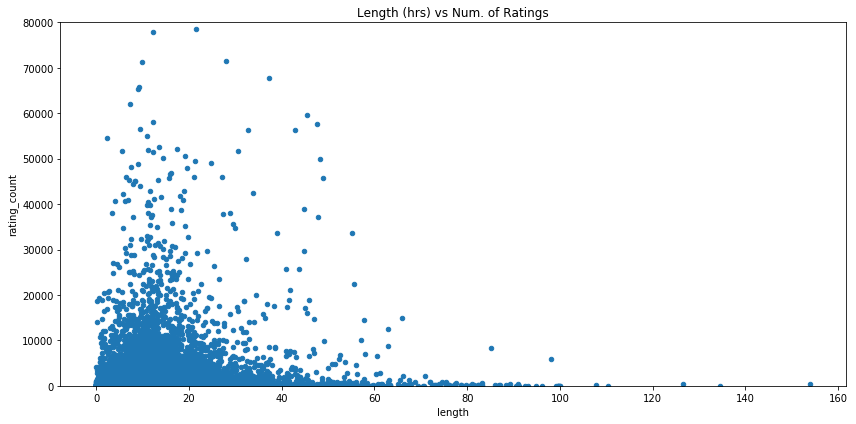

In [27]:
# Let's take a look at the 'length' feature 
df_hrs = df.copy()
df_hrs['length'] = df_hrs['length'].apply(lambda x: x/60)
df_hrs.plot.scatter(x='length', y='rating_count', figsize=(12,6), ylim=(0, 80000), 
                    title='Length (hrs) vs Num. of Ratings');
save_fig('Length vs Rating Count')

category
Sci-Fi & Fantasy         9.067023
Mysteries & Thrillers    8.573831
History                  8.493695
Name: length, dtype: float64
category
Newspapers & Magazines    0.477906
Radio & TV                1.300216
Live Events               1.514381
Name: length, dtype: float64
Saving figure Category vs Length


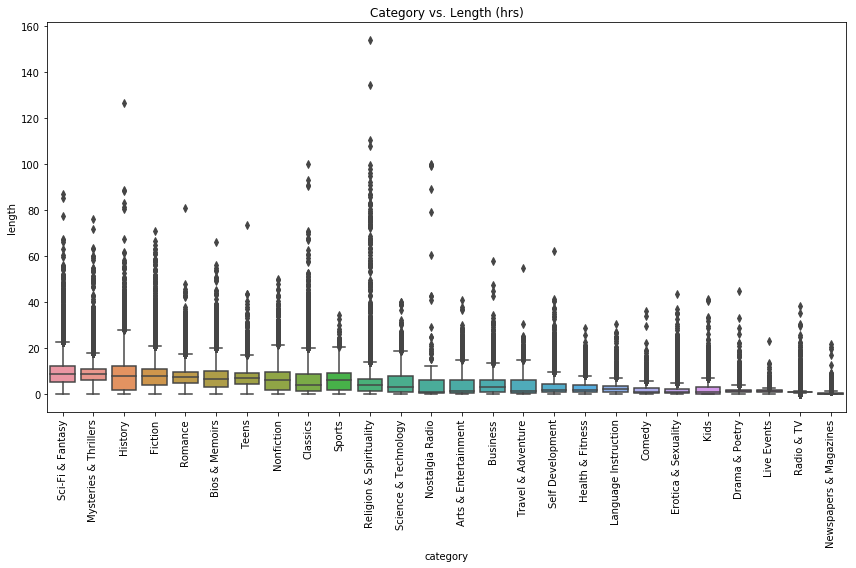

In [28]:
# Average lengths of programs in each genre

cols = df_hrs.groupby('category')['length'].mean().nlargest(26).index
plt.figure(figsize=(12,8))
bplot = sns.boxplot(x='category', y='length', 
                    data=df_hrs[(df_hrs['category'].isin(cols))], order=cols)
bplot.set_title('Category vs. Length (hrs)')
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=90, fontsize=10);
print(df.groupby('category')['length'].mean().apply(lambda x: x/60).nlargest(3))
print(df.groupby('category')['length'].mean().apply(lambda x: x/60).nsmallest(3))
save_fig('Category vs Length')

The 'Sci-Fi & Fantasy' category lays claim to the longest average title at over 9 hours. Again, we see a few outliers in the 'Religion & Spirituality' and 'History' categories. Let's find out what they are.

In [29]:
df_hrs.nlargest(5, 'length')

,title,author,narrator,rating,rating_count,release_date,length,price,category,link,asin
361188,Romans: The Greatest Letter Ever Written,John Piper,John Piper,4.5,438.0,2010-08-20,154.016667,26.83,Religion & Spirituality,https://www.audible.com/pd/Romans-The-Greatest...,B00403YYU0
362680,New American Bible,Inc. Confraternity of Christian Doctrine,Ron Dailey,4.0,24.0,2017-08-09,134.433333,29.95,Religion & Spirituality,https://www.audible.com/pd/New-American-Bible-...,B074HF9G45
126351,The Decline and Fall of the Roman Empire,Edward Gibbon,Charlton Griffin,4.5,440.0,2015-04-21,126.516667,39.95,History,https://www.audible.com/pd/The-Decline-and-Fal...,B00VXXUFYO
376063,"Luganda Contemporary Version, Audio Download",Zondervan,Odyssey Records,0.0,0.0,2017-12-26,110.466667,11.40,Religion & Spirituality,https://www.audible.com/pd/Luganda-Contemporar...,B076JL9B4L
362216,The Holy Bible,The American Bible Society,George Guidall,4.0,109.0,2016-11-14,107.716667,41.99,Religion & Spirituality,https://www.audible.com/pd/The-Holy-Bible-Audi...,B01N8U3ZJK


4 of the 5 longest programs on Audible are in the 'Religion & Spirituality' category. The longest is 154 hours. The only title outside of that category is Edward Gibbon's expansive 19th century history, 'The Decline and Fall of the Roman Empire,' which I have, incidentally (perhaps not coincidentally), fallen asleep to for years.

So there we have it. We've looked at most of our features in turn: author, narrator, rating count, release date, length, price and category. We looked at the most prolific names in the industry as well as the longest and most expensive titles. The only feature we haven't explored quite yet is the 'rating' column itself -- and that's because when we were scraping, we were only able to capture gradations of 0.5 from the html we had access to. With the links in hand, we are free to rescrape more granular ratings from the pages for individual programs, but we'll save that for another day.